# [SWCON253] Machine Learning
Teaching Assistant: Yeongwoong Kim (duddnd7575@khu.ac.kr)

Professor: Hui Yong Kim (hykim.v@khu.ac.kr)

---

# P3:  Deep Learning Framwork: Pytorch를 이용하여 MLP 구현 (10점)

### 학습목표
- pytorch를 사용하여 구현된 MLP 구조를 이해하고 수정할수 있다.
- Fashinon-MNIST 문제를 스스로 해결하면서 딥러닝 학습과정을 이해하고 하이퍼파라미터를 튜닝을 할 수 있다.

### 실습내용
pytorch를 사용하여 구현 되어 있는 MLP를 통해 Fashion-MNIST 데이터셋을 분류하는 classfier를 학습합니다.

실습은 다음 순서로 진행됩니다.
- 1) Fashon-MNIST 데이터셋 설명
- 2) Data loading
- 3) Multilayer Perceptron Model
- 4) Training
- 5) Evaluation
- 6) Discussion

아래 코드에는 2개의 퍼셉트론은 이용한 MLP 모델이 정의 되어 있습니다.
실습을 시작하기전에 이 노트북 파일을 읽고 모든 셀을 실행해하여 올바르게 작동하는지 확인하세요.<br>
이후에 아키텍쳐를 마음껏 변경하여 최고의 성능이 나오도록 수정해 보세요.

**1. 다음은 변경 가능한 부분입니다.**
- activation 함수 (logistic sigmoid, tanh, relu, leaky relu, ...)
- learning rate
- hidden layers 갯수
- epochs
- minibatch size
- 각 hidden layer의 neuron 개수

**2. 그러나 다음 사항은 변경하지 마세요.**
- 가중치 초기화 방법
- 랜덤시드
- 최적화 방법, 학습 방법

**3. layer를 추가하여 2개 이상의 hidden layer를 구성할 수 있게 구현하세요.**

**4. 수정가능한 셀은 아래 주석으로 확실하게 하이라이트되어 표시되어 있습니다.**

```
############################################################
# 변경 가능한 셀
############################################################
```

### 점수
**Test set 기준**

- 정확도 85% 이상 2점
- 정확도 86% 이상 4점
- 정확도 87% 이상 6점
- 정확도 88% 이상 8점

**구현**
- Layer 수 2개 이상으로 구현: 2점

`.ipynb 파일과 함께 .html 파일 (File -> export as -> HTML)도 함께 제출하세요. 하나만 제출할시 감점이 있습니다.`

In [1]:
import torch
import os
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
# Document: https://pytorch.org/docs/stable/nn.functional.html
import matplotlib.pyplot as plt
# Document: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
%matplotlib inline

In [2]:
# 이 부분은 절대 변경하지 마세요.

RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 1) Dataset 설명

이 데이터셋은 기존의 MNIST와 비슷하게 10개의 클래스로 이루어진 데이터셋입니다. 또한 흑백의 28x28크기, 60k개의 학습용 이미지와 10k개의 테스트용 이미지로 구성 되어 있는것과 같이 MNIST와 대부분 비슷한 구조로 이뤄져 있습니다. 

아래는 데이터셋의 샘플 이미지 입니다.

![](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

출처: https://github.com/zalandoresearch/fashion-mnist)



데이터셋의 10개의 클래스는 다음과 같습니다.


| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

## 2) Dataset Loader

In [3]:
import torch
from PIL import Image
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import os

In [4]:
# Train 데이터 로딩시 이미지 데이터 전처리를 Transforms를 통해 할 수 있습니다.
# ToTensor는 PIL 형태의 이미지나 ndarray 를 PyTorch 가 이해할 수 있는 tensor 자료형으로 바꾸어 주는 역할을 하며
# Random Flip, Random Crop 등을 사용하여 Data augmentation을 수행하고 이를 통해 좋은 성능을 얻을 수 있습니다.
# 하지만, 이번 실습에서는 사용하지 않습니다.
# Document: https://pytorch.org/vision/stable/transforms.html
custom_train_transform = transforms.Compose([  
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [5]:
# Test 데이터 로딩시 데이터 Transform
# Testset의 Trainsform은 Training set 과 다르게 랜덤하게 변경되면 안됩니다.
# 이번 실습에서는 사용하지 않습니다.
custom_test_transform = transforms.Compose([
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [6]:
############################################################
# 변경 가능한 셀
############################################################

# BATCH_SIZE = 60000을 사용하면 Full-Batch 학습
# BATCH_SIZE = 1을 사용하면 Online 학습
# BATCH_SIZE = N (1 < N < 60000) 을 사용하면 Mini-batch 학습
BATCH_SIZE = 30

In [7]:
train_dataset = FashionMNIST(".", train=True, download=True, transform=custom_train_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True,
                          num_workers=2)


test_dataset = FashionMNIST(".", train=False, download=True, transform=custom_test_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=2)

아래 셀은 데이터셋이 잘 Load 되었는지 확인하는 테스트용 코드입니다.

특히, Label data의 경우 One-hot vector encoding 되기 전의 형태의 class label 정보입니다.

In [8]:
num_epochs = 1
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        print(f'Image data shape: \t {x.shape}')
        print(f'Label data shape: \t {y.shape}')
        print(y)
        break

Epoch: 1 | Batch index: 0 | Batch size: 30
Image data shape: 	 torch.Size([30, 1, 28, 28])
Label data shape: 	 torch.Size([30])
tensor([8, 4, 0, 7, 8, 0, 3, 8, 4, 0, 8, 3, 6, 4, 5, 5, 9, 5, 9, 8, 4, 5, 3, 1,
        0, 3, 1, 3, 1, 6], device='cuda:0')


## 3) Multilayer Perceptron Model

아래 셀은 MLP모델을 정의하는 부분입니다. 이 과제에서 메인 부분입니다.<br>
Hidden layer이 2개가 되도록 변경하세요. 필요에 따라 3개 이상으로 늘려도 됩니다.

In [9]:
############################################################
# 변경 가능한 셀
############################################################

class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes # 10 
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        
        # <your code> to add layer
        self.linear_2 = torch.nn.Linear(num_hidden_1,num_hidden_2)
        self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)
        
        # Multi-class classification 문제를 풀기 위해 Softmax 함수를 사용합니다.
        self.softmax = torch.nn.Softmax(dim=-1)
        
    def forward(self, x):
        
        ### activation 함수 변경 가능
        ### 레이어간의 연결 추가, 변경
        out = self.linear_1(x)
        out = torch.relu(out)

        out = self.linear_2(out)
        out = torch.relu(out)
        
        # <your code> to set the layer and the activation function
        
        logits = self.linear_out(out)
        
        # Multi-class classification 문제를 풀기 위해 Softmax 함수를 사용합니다.
        # 다만, 이후 사용할 F.cross_entropy() 함수 내부에 softmax가 이미 구현되어 있기 때문에
        # Loss function 계산 시에는 self.softmax()를 통과하기 전의 logits 값을 이용하게 됩니다.
        probas = self.softmax(logits)
        return logits, probas

# random seed는 무작위 가중치 초기화가 항상 같도록 해줍니다.
# 초기화된 가중치에 따라 같은 네트워크도 서로 다른 성능을 낼 수 있어서 
# 실제 사용시에는 좋은 성능을 얻기 위해 여러가지 무작위 가중치를 시도해 볼 수 있습니다.
# 그러나 이 과제에서는 변경하지 않습니다.
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## 4) Training

**Cross entropy loss function 사용 시 주의점**

- 모델의 출력인 logits, probas의 차원은 [BATCH_SIZE, num_classes] 형태지만, 정답 Label인 targets 변수의 차원은 [BATCH_SIZE] 입니다. (ex, [1, 3, 2, 4, 9, ..., 3])


- 일반적으로 Cross Entropy Loss를 계산하기 위해서는 targets에 one-hot vector encoding을 수행해주어야 하지만, F.cross_entropy() 함수는 이를 내부적으로 수행해줍니다.


- 또한, F.cross_entropy() 함수 내부적으로 softmax 함수를 이용하기 때문에, 모델의 출력 중 probas 값이 아닌 logits 값을 이용하여 Loss function을 계산합니다.


- 구현 상세는 pytorch documents에서 확인할 수 있습니다. (https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html#torch.nn.functional.cross_entropy)

In [10]:
############################################################
# 변경 가능한 셀
############################################################

### num_hidden_1, num_hidden_2 변경 가능, 
### 레이어를 더 추가하고 싶다면 이부분을 알맞게 수정하세요.
model = MLP(num_features=28*28,
            num_hidden_1=200,
            num_hidden_2=200,
            num_classes=10)

model = model.to(DEVICE)


### Optimizer는 가중치를 업데이트하는 방법을 바꾸어 더 빠르게 좋은 성능을 낼 수 있도록합니다.
### 이 과제에서는 optimizer를 변경하지 않습니다. 
### 그러나 Learning Rate(lr)는 변경이 가능합니다.
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

NUM_EPOCHS = 20 # 변경 가능
############################################################

### 아래는 변경 불가능
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        
        # Loss 계산 시에는 logits 이용
        cross_entropy += F.cross_entropy(logits, targets).item()
        
        # 추론 시에는 probas 이용
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.cpu().float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, test_acc_lst = [], []
train_loss_lst, test_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 40:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        test_acc_lst.append(test_acc)
        train_loss_lst.append(train_loss)
        test_loss_lst.append(test_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Test Acc.: {test_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/020 | Batch 000/2000 | Cost: 2.3332
Epoch: 001/020 | Batch 040/2000 | Cost: 2.1646
Epoch: 001/020 | Batch 080/2000 | Cost: 1.8598
Epoch: 001/020 | Batch 120/2000 | Cost: 1.4659
Epoch: 001/020 | Batch 160/2000 | Cost: 1.4294
Epoch: 001/020 | Batch 200/2000 | Cost: 1.2106
Epoch: 001/020 | Batch 240/2000 | Cost: 1.1301
Epoch: 001/020 | Batch 280/2000 | Cost: 0.9844
Epoch: 001/020 | Batch 320/2000 | Cost: 0.8067
Epoch: 001/020 | Batch 360/2000 | Cost: 1.1405
Epoch: 001/020 | Batch 400/2000 | Cost: 0.8677
Epoch: 001/020 | Batch 440/2000 | Cost: 1.0794
Epoch: 001/020 | Batch 480/2000 | Cost: 0.7807
Epoch: 001/020 | Batch 520/2000 | Cost: 0.7067
Epoch: 001/020 | Batch 560/2000 | Cost: 0.7198
Epoch: 001/020 | Batch 600/2000 | Cost: 0.6910
Epoch: 001/020 | Batch 640/2000 | Cost: 0.7859
Epoch: 001/020 | Batch 680/2000 | Cost: 0.5696
Epoch: 001/020 | Batch 720/2000 | Cost: 0.6507
Epoch: 001/020 | Batch 760/2000 | Cost: 0.5509
Epoch: 001/020 | Batch 800/2000 | Cost: 0.5890
Epoch: 001/02

Epoch: 004/020 | Batch 760/2000 | Cost: 0.3540
Epoch: 004/020 | Batch 800/2000 | Cost: 0.1802
Epoch: 004/020 | Batch 840/2000 | Cost: 0.8816
Epoch: 004/020 | Batch 880/2000 | Cost: 0.2970
Epoch: 004/020 | Batch 920/2000 | Cost: 0.5004
Epoch: 004/020 | Batch 960/2000 | Cost: 0.3769
Epoch: 004/020 | Batch 1000/2000 | Cost: 0.5364
Epoch: 004/020 | Batch 1040/2000 | Cost: 0.6238
Epoch: 004/020 | Batch 1080/2000 | Cost: 0.1507
Epoch: 004/020 | Batch 1120/2000 | Cost: 0.6412
Epoch: 004/020 | Batch 1160/2000 | Cost: 0.5242
Epoch: 004/020 | Batch 1200/2000 | Cost: 0.4311
Epoch: 004/020 | Batch 1240/2000 | Cost: 0.6374
Epoch: 004/020 | Batch 1280/2000 | Cost: 0.2451
Epoch: 004/020 | Batch 1320/2000 | Cost: 0.3528
Epoch: 004/020 | Batch 1360/2000 | Cost: 0.3024
Epoch: 004/020 | Batch 1400/2000 | Cost: 0.2842
Epoch: 004/020 | Batch 1440/2000 | Cost: 0.8346
Epoch: 004/020 | Batch 1480/2000 | Cost: 0.4242
Epoch: 004/020 | Batch 1520/2000 | Cost: 0.3510
Epoch: 004/020 | Batch 1560/2000 | Cost: 0.449

Epoch: 007/020 | Batch 1480/2000 | Cost: 0.4162
Epoch: 007/020 | Batch 1520/2000 | Cost: 0.2166
Epoch: 007/020 | Batch 1560/2000 | Cost: 0.2461
Epoch: 007/020 | Batch 1600/2000 | Cost: 0.2126
Epoch: 007/020 | Batch 1640/2000 | Cost: 0.2750
Epoch: 007/020 | Batch 1680/2000 | Cost: 0.2711
Epoch: 007/020 | Batch 1720/2000 | Cost: 0.2526
Epoch: 007/020 | Batch 1760/2000 | Cost: 0.3707
Epoch: 007/020 | Batch 1800/2000 | Cost: 0.4790
Epoch: 007/020 | Batch 1840/2000 | Cost: 0.3483
Epoch: 007/020 | Batch 1880/2000 | Cost: 0.3161
Epoch: 007/020 | Batch 1920/2000 | Cost: 0.2738
Epoch: 007/020 | Batch 1960/2000 | Cost: 0.4769
Epoch: 007/020 Train Acc.: 88.38% | Test Acc.: 86.56%
Time elapsed: 2.14 min
Epoch: 008/020 | Batch 000/2000 | Cost: 0.2655
Epoch: 008/020 | Batch 040/2000 | Cost: 0.4063
Epoch: 008/020 | Batch 080/2000 | Cost: 0.2708
Epoch: 008/020 | Batch 120/2000 | Cost: 0.4474
Epoch: 008/020 | Batch 160/2000 | Cost: 0.3546
Epoch: 008/020 | Batch 200/2000 | Cost: 0.5466
Epoch: 008/020 | 

Epoch: 011/020 | Batch 160/2000 | Cost: 0.2130
Epoch: 011/020 | Batch 200/2000 | Cost: 0.2747
Epoch: 011/020 | Batch 240/2000 | Cost: 0.3441
Epoch: 011/020 | Batch 280/2000 | Cost: 0.3269
Epoch: 011/020 | Batch 320/2000 | Cost: 0.2381
Epoch: 011/020 | Batch 360/2000 | Cost: 0.3186
Epoch: 011/020 | Batch 400/2000 | Cost: 0.3424
Epoch: 011/020 | Batch 440/2000 | Cost: 0.2511
Epoch: 011/020 | Batch 480/2000 | Cost: 0.3887
Epoch: 011/020 | Batch 520/2000 | Cost: 0.5039
Epoch: 011/020 | Batch 560/2000 | Cost: 0.3337
Epoch: 011/020 | Batch 600/2000 | Cost: 0.1986
Epoch: 011/020 | Batch 640/2000 | Cost: 0.1922
Epoch: 011/020 | Batch 680/2000 | Cost: 0.4096
Epoch: 011/020 | Batch 720/2000 | Cost: 0.3141
Epoch: 011/020 | Batch 760/2000 | Cost: 0.3405
Epoch: 011/020 | Batch 800/2000 | Cost: 0.3221
Epoch: 011/020 | Batch 840/2000 | Cost: 0.1873
Epoch: 011/020 | Batch 880/2000 | Cost: 0.4334
Epoch: 011/020 | Batch 920/2000 | Cost: 0.2205
Epoch: 011/020 | Batch 960/2000 | Cost: 0.1396
Epoch: 011/02

Epoch: 014/020 | Batch 880/2000 | Cost: 0.3979
Epoch: 014/020 | Batch 920/2000 | Cost: 0.0951
Epoch: 014/020 | Batch 960/2000 | Cost: 0.3283
Epoch: 014/020 | Batch 1000/2000 | Cost: 0.3560
Epoch: 014/020 | Batch 1040/2000 | Cost: 0.2678
Epoch: 014/020 | Batch 1080/2000 | Cost: 0.4214
Epoch: 014/020 | Batch 1120/2000 | Cost: 0.5653
Epoch: 014/020 | Batch 1160/2000 | Cost: 0.4642
Epoch: 014/020 | Batch 1200/2000 | Cost: 0.3032
Epoch: 014/020 | Batch 1240/2000 | Cost: 0.1229
Epoch: 014/020 | Batch 1280/2000 | Cost: 0.2533
Epoch: 014/020 | Batch 1320/2000 | Cost: 0.2578
Epoch: 014/020 | Batch 1360/2000 | Cost: 0.5330
Epoch: 014/020 | Batch 1400/2000 | Cost: 0.2011
Epoch: 014/020 | Batch 1440/2000 | Cost: 0.1553
Epoch: 014/020 | Batch 1480/2000 | Cost: 0.1118
Epoch: 014/020 | Batch 1520/2000 | Cost: 0.5810
Epoch: 014/020 | Batch 1560/2000 | Cost: 0.3015
Epoch: 014/020 | Batch 1600/2000 | Cost: 0.1101
Epoch: 014/020 | Batch 1640/2000 | Cost: 0.3958
Epoch: 014/020 | Batch 1680/2000 | Cost: 0.

Epoch: 017/020 | Batch 1640/2000 | Cost: 0.2402
Epoch: 017/020 | Batch 1680/2000 | Cost: 0.1687
Epoch: 017/020 | Batch 1720/2000 | Cost: 0.2512
Epoch: 017/020 | Batch 1760/2000 | Cost: 0.3306
Epoch: 017/020 | Batch 1800/2000 | Cost: 0.3795
Epoch: 017/020 | Batch 1840/2000 | Cost: 0.2579
Epoch: 017/020 | Batch 1880/2000 | Cost: 0.1443
Epoch: 017/020 | Batch 1920/2000 | Cost: 0.2318
Epoch: 017/020 | Batch 1960/2000 | Cost: 0.1294
Epoch: 017/020 Train Acc.: 91.15% | Test Acc.: 88.09%
Time elapsed: 5.10 min
Epoch: 018/020 | Batch 000/2000 | Cost: 0.3059
Epoch: 018/020 | Batch 040/2000 | Cost: 0.1701
Epoch: 018/020 | Batch 080/2000 | Cost: 0.3510
Epoch: 018/020 | Batch 120/2000 | Cost: 0.1761
Epoch: 018/020 | Batch 160/2000 | Cost: 0.1440
Epoch: 018/020 | Batch 200/2000 | Cost: 0.3312
Epoch: 018/020 | Batch 240/2000 | Cost: 0.1476
Epoch: 018/020 | Batch 280/2000 | Cost: 0.3385
Epoch: 018/020 | Batch 320/2000 | Cost: 0.2204
Epoch: 018/020 | Batch 360/2000 | Cost: 0.1239
Epoch: 018/020 | Batc

## 5) Evaluation

테스트 데이터와 학습 데이터의 Loss변화를 확인합니다.

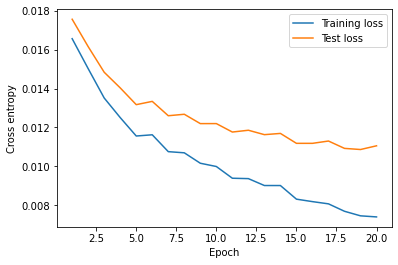

In [11]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), test_loss_lst, label='Test loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

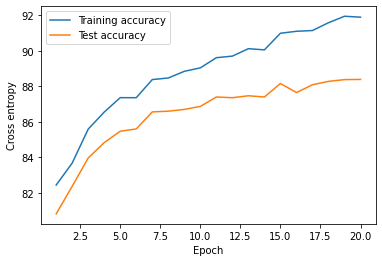

In [12]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), test_acc_lst, label='Test accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [13]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 88.39%


## 6) Discussion

**1) 학습, 테스트 정확도는 얼마인가요? (위 숫자를 복사하세요.)**

- Training:  91.90%
- Test: 88.39%

**2) overfitting을 경험했나요? 만약 그랬다면 왜 그랬을지 적어보고, overfitting을 방지하기위한 간단한 방법은 무엇일까요?**

[제안하는 방법 적기]
층이 깊을 때, 오버피팅이 발생하였는데, 층을 2개로 바꾸니 오버피팅이 해결되었다. 층이 깊어질수록 파라미터의 갯수가 증가하여 트레이닝 데이터에 더 잘 맞기 때문에 발생한다.
은닉층의 노드를 300개로 했을때, 오버피팅이 발생하였다. 이 역시 파라미터 수가 많아져서 발생한 문제이고, 은닉층의 노드를 200개로 하니 오버피팅이 줄어들었다.

예를 들면, 

- batch size를 256으로 변경
- 두개의 hidden layers의 activation을 relu로 변경
- learning rate를 0.2로 변경

**3) 만약 hidden layer 수가 늘어나면(3개 이상) 얻을 수 있는 장/단점은 무엇일까요?**

[답변작성] 깊이가 깊어질수록 훈련데이터와의 적합도가 올라간다. 그러나 오버피팅이 발생하여 테스트데이터와의 적합도가 감소할수 있다는 문제점이 있다. 또한 비선형 다차원 데이터를 종더 정교하게 예픅할수 있지만, 그래디언트 소멸과 많은 연산 등 단점도 또한 존재한다.

**4) 구현하면서 수정한 부분에 대해 작성하여 수정한 이유 및 성능향상이 생긴 이유에 대해 답해보세요.**

[답변작성]활성함수를 시그모이드 대신 렐루함수로 바꿨다. 시그모이드함수는 여러층을 거칠수록 기울기가 작아지기 때문에 그래디언트 소멸 문제가 발생한다. 따라서, 이를 막기 위해 ReLU함수로 수정했다.
학습률이 기존에 1로 설정되어 있던것을 0.01로 바꿨다. 1일 땐, 너무 크게 가중치가 변화하기 때문에 원하는 최적값을 지나칠수 있어서 이를 수정하였다.
은닉층 갯수도 200개로 바꿨다. 은닉층이 많아지면, 파라미터수가 증가하여 과소적합 문제를 해결할 수 있기 때문에 이를 수정했다.
에포크를 20으로 바꿨다. 실행할 수록 정확도가 올라가는 것을 관찰하고, 일정 수준까지 에포크를 증가시키면 꾸준히 정확도가 올라가길래 적절한 범위까지 에포크를 증가시켰다.
미니배치사이즈를 30으로 수정했다. 너무클땐, 수렴속도가 늦어지고, 로컬미니마에 빠질수 있어서 안좋았고, 너무 작을땐, 너무 불필요한 데이터까지 업데이트해서 안좋았다. 따라서, 적절한 값인 30으로 설정했다.
은닉층의 깊이도 2층으로 바꿨다. 논문에 따르면, 은닉층이 3개 4개로 증가할수록 정확도가 내려간다고 한다. 층이 깊어질수록 local minima에 빠져나오기 힘들기 때문이다. 그래서 은닉층의 깊이를 2층으로 바꿨다.